In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
import csv
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from ampy import StabilitySelectionVAMPSolver
from ampy import utils

%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
np.random.seed(0)

# load data

## random DCT
* α = 0.1, σ = 0.1, N = 4096

In [4]:
random_DCT_data_A = pd.read_csv("./data/random_DCT/random_DCT_X_alpha01.csv", header=None)
random_DCT_data_y = pd.read_csv("./data/random_DCT/random_DCT_y_alpha01.csv", header=None)
A_dct = np.array(random_DCT_data_A, dtype=np.float64)
y_dct = np.array(random_DCT_data_y, dtype=np.float64).reshape(A_dct.shape[0], )

A_dct -= A_dct.mean(axis=0)
A_dct /= A_dct.std(axis=0)
y_dct -= y_dct.mean()

A_dct.shape, y_dct.shape

((409, 4096), (409,))

In [5]:
n_sampe_matlab = 100000
lasso_solution_array_dct = np.empty((4096, n_sampe_matlab), dtype=np.float64)
with open("./data/random_DCT/naive_re-estimation_based_result/matlab_result.csv") as f:
    reader = csv.reader(f, delimiter=",")
    for row_index, row in tqdm(enumerate(reader), total=4096):
        lasso_solution_array_dct[row_index] = row

lasso_solution_array_dct = lasso_solution_array_dct.T

## riboflavin

In [6]:
riboflavin_data_A = pd.read_csv("./data/riboflavin/X.csv", header=None)
riboflavin_data_y = pd.read_csv("./data/riboflavin/y.csv", header=None)
A_ribo = np.array(riboflavin_data_A, dtype=np.float64)
y_ribo = np.array(riboflavin_data_y, dtype=np.float64).reshape(A_ribo.shape[0], )
A_ribo -= A_ribo.mean(axis=0)
A_ribo /= A_ribo.std(axis=0)
y_ribo -= y_ribo.mean()
A_ribo.shape, y_ribo.shape

((71, 4088), (71,))

In [7]:
n_sampe_matlab = 100000
lasso_solution_array_ribo = np.empty((4088, n_sampe_matlab), dtype=np.float64)
with open("./data/riboflavin/naive_re-estimation_based_result/matlab_result.csv") as f:
    reader = csv.reader(f, delimiter=",")
    for row_index, row in tqdm(enumerate(reader), total=4088):
        lasso_solution_array_ribo[row_index] = row

lasso_solution_array_ribo = lasso_solution_array_ribo.T

# choose regularization strength

## random DCT

In [8]:
lasso_cv_dct = linear_model.LassoCV(n_jobs=3, n_alphas=50, cv=10, tol=1e-3, max_iter=1e7, fit_intercept=False)
lasso_cv_dct.fit(A_dct, y_dct)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=False,
    max_iter=10000000.0, n_alphas=50, n_jobs=3, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.001, verbose=False)

In [9]:
lasso_cv_dct.alpha_

0.019965269054807513

## riboflavin

In [10]:
lasso_cv_ribo = linear_model.LassoCV(n_jobs=3, n_alphas=100, cv=10, tol=1e-3, max_iter=1e7, fit_intercept=False)
lasso_cv_ribo.fit(A_ribo, y_ribo)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=False,
    max_iter=10000000.0, n_alphas=100, n_jobs=3, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.001, verbose=False)

In [11]:
lasso_cv_ribo.alpha_

0.023956316391668977

# VAMP

## random DCT

In [12]:
μ = int(A_dct.shape[0]/2.0)/ A_dct.shape[0]
μ

0.49877750611246946

In [13]:
%%time
dumping = 1.0
tol = 1e-12
message=False
vamp_solver_dct = StabilitySelectionVAMPSolver(A_dct, y_dct, 
                                               regularization_strength= lasso_cv_dct.alpha_ * A_dct.shape[0] * np.ones(A_dct.shape[1]), 
                                               dumping_coefficient=dumping, mu=μ, clip_min=1e-12, clip_max=1e12)

hoge = vamp_solver_dct.solve(max_iteration=100, tolerance=tol, message=message)

CPU times: user 2min 28s, sys: 17.2 s, total: 2min 46s
Wall time: 1min 6s


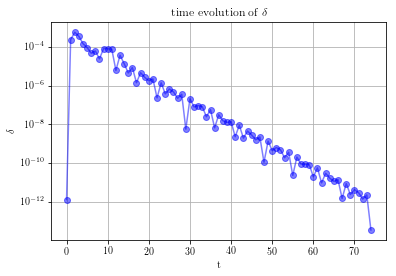

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(vamp_solver_dct.diff_history, "o-", c="b", alpha=0.5)
ax.set_yscale("log")
ax.set_title("time evolution of $\delta$")
ax.set_xlabel("t")
ax.set_ylabel("$\delta$")
ax.grid()

## riboflavin

In [15]:
%%time
dumping = 1.0
tol = 1e-12
message=False
vamp_solver_ribo = StabilitySelectionVAMPSolver(A_ribo, y_ribo, 
                                               regularization_strength= lasso_cv_ribo.alpha_ * A_ribo.shape[0] * np.ones(A_ribo.shape[1]), 
                                               dumping_coefficient=dumping, mu=μ, clip_min=1e-12, clip_max=1e12)

hoge = vamp_solver_ribo.solve(max_iteration=100, tolerance=tol, message=message)

CPU times: user 40.5 s, sys: 7.86 s, total: 48.4 s
Wall time: 25.6 s


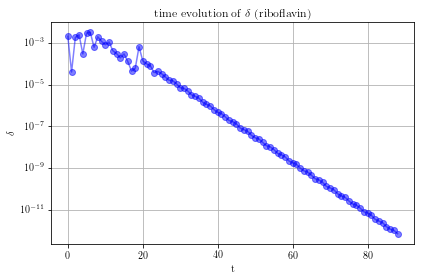

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(vamp_solver_ribo.diff_history, "o-", c="b", alpha=0.5)
ax.set_yscale("log")
ax.set_yscale("log")
ax.set_title("time evolution of $\delta$ (riboflavin)")
ax.set_xlabel("t")
ax.set_ylabel("$\delta$")
ax.grid()
fig.tight_layout()

# plot figure

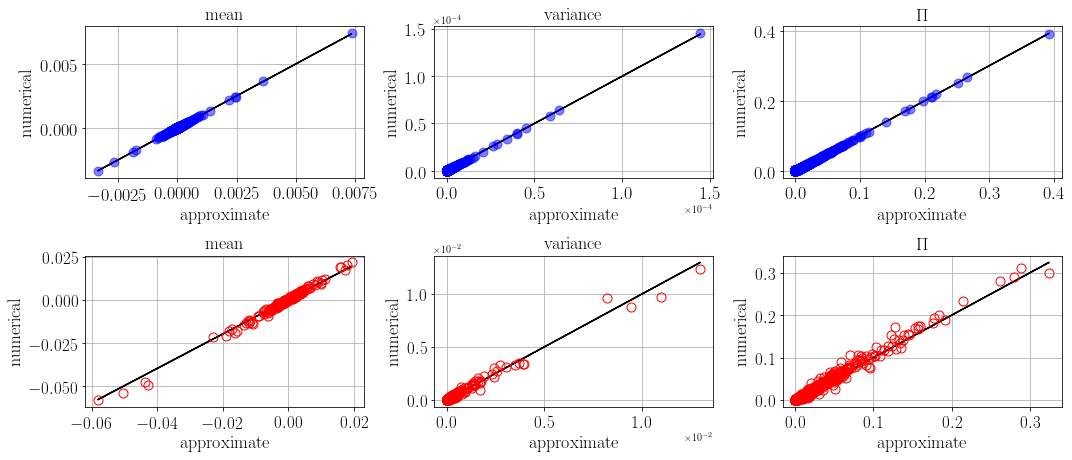

In [17]:
fig = plt.figure(figsize=(15, 6.5))
ax = fig.add_subplot(231)
ax.plot(vamp_solver_dct.x1_hat, vamp_solver_dct.x1_hat, "-", c="k")
ax.plot(vamp_solver_dct.x1_hat, lasso_solution_array_dct.mean(axis=0), "o", c="b", alpha=0.5, ms=9)
ax.grid()
ax.set_title("mean", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=18)


ax = fig.add_subplot(232)
ax.plot(vamp_solver_dct.v1x, vamp_solver_dct.v1x, "-", c="k")
ax.plot(vamp_solver_dct.v1x, lasso_solution_array_dct.var(axis=0), "o", c="b", alpha=0.5, ms=9)
ax.grid()
ax.set_title("variance", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=18)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


ax = fig.add_subplot(233)
ax.plot(vamp_solver_dct.chi1x * vamp_solver_dct.q1x_hat, vamp_solver_dct.chi1x * vamp_solver_dct.q1x_hat, "-", c="k")
ax.plot(vamp_solver_dct.chi1x * vamp_solver_dct.q1x_hat, (lasso_solution_array_dct!=0.0).mean(axis=0), "o", c="b", alpha=0.5, ms=9)
ax.grid()
ax.set_title("$\Pi$", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=18)

# riboflavin
ax = fig.add_subplot(234)
ax.plot(vamp_solver_ribo.x1_hat, vamp_solver_ribo.x1_hat, "-", c="k")
ax.plot(vamp_solver_ribo.x1_hat, lasso_solution_array_ribo.mean(axis=0), "o", c="r", alpha=1.0, fillstyle="none", ms=9)
ax.grid()
ax.set_title("mean", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=17)


ax = fig.add_subplot(235)
ax.plot(vamp_solver_ribo.v1x, vamp_solver_ribo.v1x, "-", c="k")
ax.plot(vamp_solver_ribo.v1x, lasso_solution_array_ribo.var(axis=0), "o", c="r", alpha=1.0, fillstyle="none", ms=9)
ax.grid()
ax.set_title("variance", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=17)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


ax = fig.add_subplot(236)
ax.plot(vamp_solver_ribo.chi1x * vamp_solver_ribo.q1x_hat, vamp_solver_ribo.chi1x * vamp_solver_ribo.q1x_hat, "-", c="k")
ax.plot(vamp_solver_ribo.chi1x * vamp_solver_ribo.q1x_hat, (lasso_solution_array_ribo!=0.0).mean(axis=0), "o", c="r", alpha=1.0, fillstyle="none", ms=9)
ax.grid()
ax.set_title("$\Pi$", fontsize=18)
ax.set_xlabel("approximate", fontsize=18)
ax.set_ylabel("numerical", fontsize=18)
ax.tick_params(labelsize=17)

fig.tight_layout()

In [18]:
fig.savefig("./accuracy.png", dpi=100, transparent=False)
fig.savefig("./accuracy_transparent.png", dpi=100, tranceparent=True)